# 1. Import Libraries

In [133]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans,k_means
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd

# 2. Preparing Dataset

## 2.1 Yelp Open Dataset

Yelp Open Dataset is an open dataset released by Yelp for learning purposes. It consists of millions of user reviews, businesses attributes and over 200,000 pictures from multiple metropolitan areas
- Size: 2.66 GB JSON 
- Number of Records: 5,200,000 reviews, 174,000 business attributes, 200,000 pictures etc.
     > We only used Business JSON fiel to conduct an analysis. An example of the Business JSON file:
       [{'business_id': 'Apn5Q_b6Nz61Tq4XzPdf9A',
         'name': 'Minhas Micro Brewery',
         'neighborhood': '',
         'address': '1314 44 Avenue NE',
         'city': 'Calgary',
         'state': 'AB',
         'postal_code': 'T2E 6L6',
         'latitude': 51.0918130155,
         'longitude': -114.031674872,
         'stars': 4.0,
         'review_count': 24,
         'is_open': 1,
         'attributes': {'BikeParking': 'False',
          'BusinessAcceptsCreditCards': 'True',
          'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
          'GoodForKids': 'True',
          'HasTV': 'True',
          'NoiseLevel': 'average',
          'OutdoorSeating': 'False',
          'RestaurantsAttire': 'casual',
          'RestaurantsDelivery': 'False',
          'RestaurantsGoodForGroups': 'True',
          'RestaurantsPriceRange2': '2',
          'RestaurantsReservations': 'True',
          'RestaurantsTakeOut': 'True'},
         'categories': 'Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel',
         'hours': {'Monday': '8:30-17:0',
          'Tuesday': '11:0-21:0',
          'Wednesday': '11:0-21:0',
          'Thursday': '11:0-21:0',
          'Friday': '11:0-21:0',
          'Saturday': '11:0-21:0'}},
           ...]

## 2.2 Data Cleaning 

### 2.2.1 Read JSON file

In [134]:
data = []
with open('yelp_academic_dataset_business.json') as f:
    for line in f:
        data.append(json.loads(line))

### 2.2.2 Convert the JSON file to DataFrame and drop the rows if the `attribute` is NAN

In [135]:
df = pd.DataFrame(data)
df.dropna(subset=['attributes'],inplace=True)

### 2.2.3 Insert the `RestaurantsPriceRange2` ( Yelp $ Signs)

In [136]:
df_attribute = pd.DataFrame([i if i != None else {'RestaurantsPriceRange2':np.NAN} for i in df['attributes']])

In [137]:
df['dollar_sign'] = df_attribute['RestaurantsPriceRange2']

In [138]:
df = df[['business_id', 'categories','latitude','longitude', 'name','postal_code','dollar_sign']]

In [139]:
df.head()

,business_id,categories,latitude,longitude,name,postal_code,dollar_sign
0,Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",51.091813,-114.031675,Minhas Micro Brewery,T2E 6L6,2
1,AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",35.960734,-114.939821,CK'S BBQ & Catering,89002,2
2,O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",45.540503,-73.599300,La Bastringue,H2G 1K7,2
4,8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",51.035591,-114.027366,Action Engine,T2H 0N5,1
5,45bWSZtniwPRiqlivpS8Og,"Coffee & Tea, Food",33.671375,-112.030017,The Coffee Bean & Tea Leaf,85024,1


### 2.2.4 Missing values

In [140]:
df.isnull().sum()

business_id        0
categories        57
latitude           5
longitude          4
name               0
postal_code        0
dollar_sign    70325
dtype: int64

In [141]:
df['categories'] = df['categories'].fillna('None')

In [142]:
df.dropna(inplace=True)

In [143]:
df.isnull().sum()

business_id    0
categories     0
latitude       0
longitude      0
name           0
postal_code    0
dollar_sign    0
dtype: int64

### 2.2.6 Select only 5 digit US postal_code 

In [292]:
df = df[df.postal_code.str.match("\d{5}")]

### 2.2.5_1 ** Post_code Dataset**  Reset the Index as US postal_code

In [293]:
df_post = df.set_index('postal_code')

pivoted = pd.pivot_table(df_post, index='postal_code', columns='dollar_sign', values='business_id', aggfunc="count",fill_value=0)

flattened = pd.DataFrame(pivoted.to_records())

df_post = flattened.rename(columns={'1':'yelp_dollar_1','2':'yelp_dollar_2','3':'yelp_dollar_3','4':'yelp_dollar_4'})

df_post['Total_Business'] = df_post['yelp_dollar_1'] + df_post['yelp_dollar_2'] +  df_post['yelp_dollar_3'] + df_post['yelp_dollar_4']

In [294]:
!ls

EDA.ipynb
IRS_zipcodes_clean.csv
Neighborhood_PriceToRentRatio_AllHomes.csv
SQL_lecture_DS.ipynb
twitter_2018-12-29_1546886415.json
yelp_academic_dataset_business.json
zillow-neighborhoods.geojson


In [295]:
IRS = pd.read_csv('./IRS_zipcodes_clean.csv')

In [296]:
IRS = IRS.rename(columns={'zipcode':'postal_code',
                          '1':'income_level_1',
                          '2':'income_level_2',
                          '3':'income_level_3',
                          '4':'income_level_4',
                          '5':'income_level_5',
                          '6':'income_level_6'})

In [297]:
df_post.postal_code = df_post.postal_code.astype('int64')

In [298]:
df_post = df_post.merge(IRS,on='postal_code',how='inner')

In [302]:
df_post.dtypes

postal_code         int64
yelp_dollar_1       int64
yelp_dollar_2       int64
yelp_dollar_3       int64
yelp_dollar_4       int64
Total_Business      int64
STATE              object
income_level_1    float64
income_level_2    float64
income_level_3    float64
income_level_4    float64
income_level_5    float64
income_level_6    float64
dtype: object

In [304]:
df_post.to_csv('yelp_IRS_zipcode.csv')


|Variables| dtype| description |
|-------|----|-----|
|postal_code|int64|zipcode|
|yelp_dollar_1|int|the number of businesses which have 1 dollar signs in this zipcode area|
|yelp_dollar_2|int|the number of businesses which have 2 dollar signs in this zipcode area|
|yelp_dollar_3|int|the number of businesses which have 3 dollar signs in this zipcode area|
|yelp_dollar_4|int|the number of businesses which have 4 dollar signs in this zipcode area|
|Total_Business|int|the totoal number of businsess in this zipcode area|
|STATE|object|States|
|income_level_1|float|the number of people whose income level lie in level_1 category(statistics from IRS)|
|income_level_2|float|the number of people whose income level lie in level_2 category(statistics from IRS)|
|income_level_3|float|the number of people whose income level lie in level_3 category(statistics from IRS)|
|income_level_4|float|the number of people whose income level lie in level_4 category(statistics from IRS)|
|income_level_5|float|the number of people whose income level lie in level_5 category(statistics from IRS)|
|income_level_6|float|the number of people whose income level lie in level_6 category(statistics from IRS)|

### 2.2.5_2 **Neighborhood Name Dataset** Define the neighborhood 

**Outside Data**

In [219]:
df_neighbor = df

In [220]:
zillow = gpd.read_file('./zillow-neighborhoods.geojson')

In [221]:
df_neighbor['geometry'] = list(zip(df_neighbor.longitude, df_neighbor.latitude))
df_neighbor['geometry'] = df_neighbor['geometry'].apply(lambda x: Point(x)) 

In [222]:
zillow_geo = gpd.GeoDataFrame(zillow[['regionid','geometry','name','city']])
yelp_geo = gpd.GeoDataFrame(df_neighbor[['business_id','geometry','categories','dollar_sign','postal_code']]) 

In [223]:
zillow_geo.isnull().sum()

regionid     0
geometry    28
name         0
city         0
dtype: int64

In [224]:
zillow_geo.dropna(inplace=True)

merged_geos = gpd.sjoin(yelp_geo, zillow_geo, op='within',how='left').fillna('NoNeighborhood')

merged_geos.rename(columns={'name':'neighborhood','geometry':'point_location'},inplace=True)

df_neighbor = pd.DataFrame(merged_geos)

df_neighbor.set_index('neighborhood',inplace=True)

pivoted = pd.pivot_table(df_neighbor, index=['neighborhood','city'], columns='dollar_sign', values='business_id', aggfunc="count",fill_value=0)

flattened = pd.DataFrame(pivoted.to_records())

df_neighbor = flattened.rename(columns={'1':'yelp_dollar_1','2':'yelp_dollar_2','3':'yelp_dollar_3','4':'yelp_dollar_4'})

df_neighbor['Total_Business'] = df_neighbor['yelp_dollar_1'] + df_neighbor['yelp_dollar_2'] +  df_neighbor['yelp_dollar_3'] + df_neighbor['yelp_dollar_4']

df_zillow = pd.DataFrame(zillow)

df_zillow.rename(columns={'name':'neighborhood'},inplace=True)

df_neighbor = df_neighbor.merge(df_zillow,on=['neighborhood','city'],how='inner')

In [250]:
Rent = pd.read_csv('./Neighborhood_PriceToRentRatio_AllHomes.csv')

In [252]:
Rent = Rent[['RegionID','2018-11']]

In [254]:
Rent.rename(columns={'RegionID':'regionid','2018-11':'Rent'},inplace=True)

In [262]:
df_neighbor.regionid = df_neighbor.regionid.astype('int64')

In [264]:
df_neighbor = df_neighbor.merge(Rent,on='regionid',how='inner')

In [306]:
df_neighbor.dtypes

neighborhood       object
city               object
yelp_dollar_1       int64
yelp_dollar_2       int64
yelp_dollar_3       int64
yelp_dollar_4       int64
Total_Business      int64
regionid            int64
county             object
state              object
geometry           object
Rent              float64
dtype: object

In [305]:
df_neighbor.to_csv('yelp_zillow_neighborhood.csv')

|Variables| dtype| description |
|-------|----|-----|
|Neighborhood|object|Neighborhood names|
|city|object|city names|
|regionid|int|ID from Zillow reserach data to identify unique neighborhood|
|state|object|state|
|county|object|county|
|geometry|object|Polygon values for boundary of neighborhood, can be further used for mapping)
|yelp_dollar_1|int|the number of businesses which have 1 dollar signs in this zipcode area|
|yelp_dollar_2|int|the number of businesses which have 2 dollar signs in this zipcode area|
|yelp_dollar_3|int|the number of businesses which have 3 dollar signs in this zipcode area|
|yelp_dollar_4|int|the number of businesses which have 4 dollar signs in this zipcode area|
|Total_Business|int|the totoal number of businsess in this zipcode area|
|STATE|object|States|
|Rent|float|Rent p

In [14]:
Restaurants = df[(df['categories'].str.contains('Restaurants')) | (df['categories'].str.contains('Food')) ]

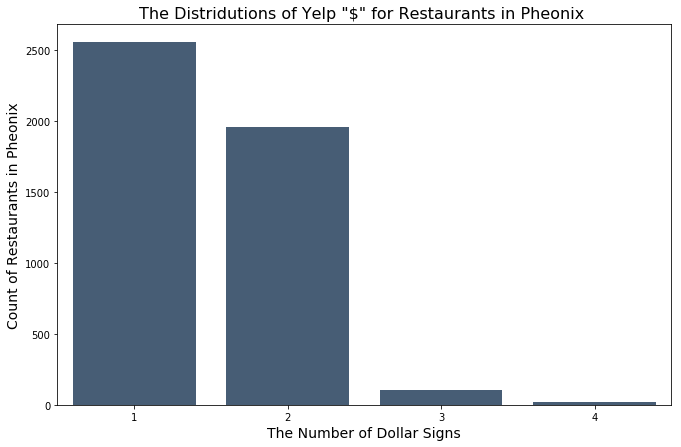

In [17]:
plt.figure(figsize=(11,7));
sns.countplot(Restaurants['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for Restaurants in Pheonix ', fontsize=16);

In [18]:
American = Restaurants[Restaurants['categories'].str.contains('American')]

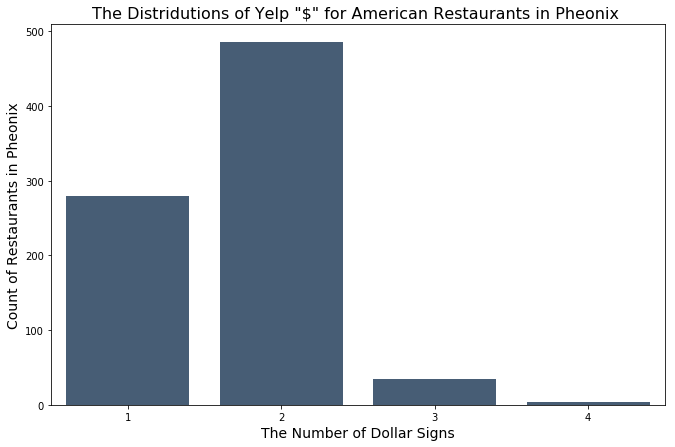

In [19]:
plt.figure(figsize=(11,7));
sns.countplot(American['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for American Restaurants in Pheonix ', fontsize=16);

In [20]:
Chinese = Restaurants[Restaurants['categories'].str.contains('Chinese')]

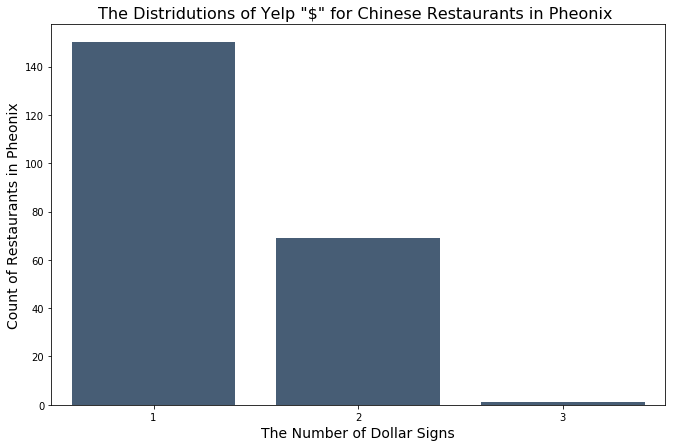

In [21]:
plt.figure(figsize=(11,7));
sns.countplot(Chinese['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for Chinese Restaurants in Pheonix ', fontsize=16);

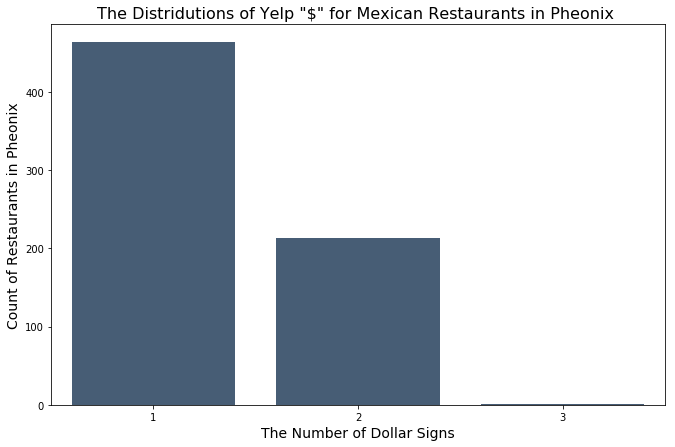

In [22]:
Mexican = Restaurants[Restaurants['categories'].str.contains('Mexican')]
plt.figure(figsize=(11,7));
sns.countplot(Mexican['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for Mexican Restaurants in Pheonix ', fontsize=16);

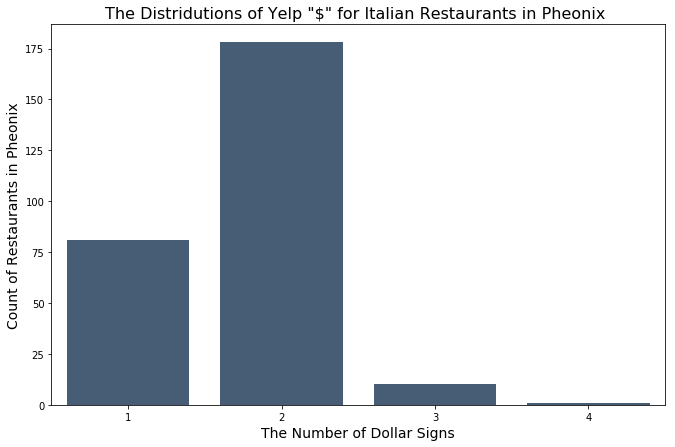

In [23]:
Italian = Restaurants[Restaurants['categories'].str.contains('Italian')]
plt.figure(figsize=(11,7));
sns.countplot(Italian['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for Italian Restaurants in Pheonix ', fontsize=16);

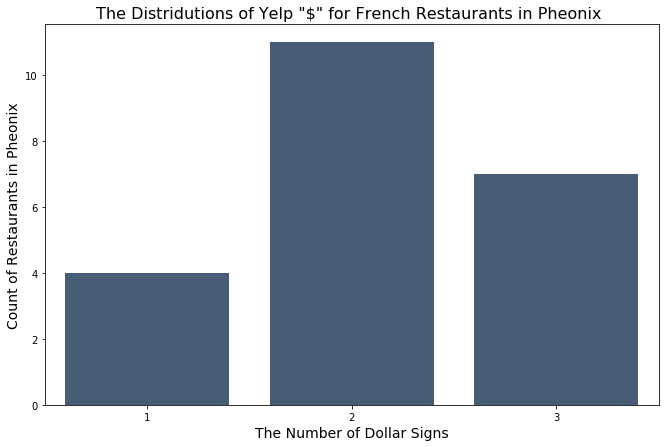

In [24]:
French = Restaurants[Restaurants['categories'].str.contains('French')]
plt.figure(figsize=(11,7));
sns.countplot(French['dollar'], color = "#3F5D7D");
plt.xlabel('The Number of Dollar Signs', fontsize=14);
plt.ylabel('Count of Restaurants in Pheonix',fontsize=14);
plt.title('The Distridutions of Yelp "$" for French Restaurants in Pheonix ', fontsize=16);

In [37]:
zillow = gpd.read_file('/Users/janeliang/Downloads/zillow-neighborhoods.geojson')

In [38]:
zillow.head()

,city,name,regionid,county,state,geometry
0,Chicago,Dunning,138129,Cook,IL,"POLYGON ((-87.78618999999989 41.94558, -87.786..."
1,Danville,Vermilipn Heights,140779,Vermilion,IL,POLYGON ((-87.65849448899995 40.12343103000006...
2,Springfield,Jefferson Park,195637,Sangamon,IL,"POLYGON ((-89.700805 39.812098, -89.696901 39...."
3,Chicago,Gresham,269571,Cook,IL,"POLYGON ((-87.6337397026425 41.72996999541133,..."
4,Chicago,South Shore,269608,Cook,IL,"POLYGON ((-87.56564699999987 41.774134, -87.56..."


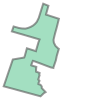

In [39]:
zillow.geometry[39]

In [40]:
!pip install shapely

In [41]:
df['geometry'] = list(zip(df.longitude, df.latitude))
df['geometry'] = df['geometry'].apply(lambda x: Point(x)) 

In [42]:
zillow_geo = gpd.GeoDataFrame(zillow[['regionid','geometry']])
yelp_geo = gpd.GeoDataFrame(df[['business_id','geometry']]) 

In [43]:
zillow_geo.dropna(inplace=True)

In [44]:
yelp_geo.head()

,business_id,geometry
0,45bWSZtniwPRiqlivpS8Og,POINT (-112.0300171 33.6713751)
1,_c3ixq9jYKxhLUB0czi0ug,POINT (-112.0911877 33.4798071)
2,3ByGQOVgds2YEu6kzl-XEQ,POINT (-112.2360764 33.4952976)
3,CeuTRtwsq6w5rztGOyNMPg,POINT (-112.2251729 33.4796712)
4,AcGRSWCpb7YB95MTsHlGEw,POINT (-112.235797843 33.4954215852)


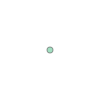

In [45]:
yelp_geo.geometry[1]

In [46]:
merged_geos = gpd.sjoin(yelp_geo, zillow_geo, op='within',how='left').fillna('NoNeighborhood')

In [48]:
merged_geos.head()

,business_id,geometry,index_right,regionid
0,45bWSZtniwPRiqlivpS8Og,POINT (-112.0300171 33.6713751),2081,112547
1,_c3ixq9jYKxhLUB0czi0ug,POINT (-112.0911877 33.4798071),6978,267926
2,3ByGQOVgds2YEu6kzl-XEQ,POINT (-112.2360764 33.4952976),6092,112345
3,CeuTRtwsq6w5rztGOyNMPg,POINT (-112.2251729 33.4796712),6092,112345
4,AcGRSWCpb7YB95MTsHlGEw,POINT (-112.235797843 33.4954215852),6092,112345


In [49]:
merged_geo = pd.DataFrame(merged_geos[['business_id','regionid']])

In [50]:
df.merge(merged_geo,on ='business_id',how='left')

,index,business_id,categories,latitude,longitude,name,postal_code,dollar,geometry,regionid
0,1,45bWSZtniwPRiqlivpS8Og,"Coffee & Tea, Food",33.671375,-112.030017,The Coffee Bean & Tea Leaf,85024,1,POINT (-112.0300171 33.6713751),112547
1,2,_c3ixq9jYKxhLUB0czi0ug,"Bars, Sports Bars, Dive Bars, Burgers, Nightli...",33.479807,-112.091188,Original Hamburger Works,85007,1,POINT (-112.0911877 33.4798071),267926
2,3,3ByGQOVgds2YEu6kzl-XEQ,"Nightlife, Bars, American (Traditional), Sport...",33.495298,-112.236076,Rib Shop,85033,1,POINT (-112.2360764 33.4952976),112345
3,4,CeuTRtwsq6w5rztGOyNMPg,"Mexican, Restaurants",33.479671,-112.225173,Salsitas,85033,1,POINT (-112.2251729 33.4796712),112345
4,6,AcGRSWCpb7YB95MTsHlGEw,"Pizza, Fast Food, Restaurants",33.495422,-112.235798,Little Caesars Pizza,85033,1,POINT (-112.235797843 33.4954215852),112345
5,8,cKRMmytHxaSt8F0SMEzKqg,"Event Planning & Services, Soup, Salad, Mexica...",33.639774,-112.087738,Manuel's Mexican Restaurant & Cantina - Bell Rd,85023,2,POINT (-112.0877381 33.6397742),111818
6,9,dYBF1MFzxo6DehQVYsjxXA,"Beauty & Spas, Makeup Artists, Hair Salons, Ey...",33.406453,-112.280777,Makeupbygaby1974,85353,2,POINT (-112.2807774 33.406453),273652
7,11,qBd6uxX63lQuM7lzJ_Xihg,"Beer, Wine & Spirits, Food",33.480792,-112.150881,Jack's Liquor,85019,2,POINT (-112.1508807 33.4807922),112345
8,14,HHjQWysnOJiW2qYQR-SSJQ,"Discount Store, Wholesale Stores, Shopping, Ou...",33.445514,-112.032068,Bargain Store Equipment,85034,2,POINT (-112.0320681 33.4455139),267912
9,19,8vA1d9_w4hBjOcrM7mNWFg,"American (Traditional), Comfort Food, Barbeque...",33.320252,-111.982873,Boston Market,85044,1,POINT (-111.9828733 33.3202518),267900


In [ ]:
import plotly.plotly as py
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['state'] + '<br>' +\
    'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
    'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
    'Wheat '+df['wheat']+' Corn '+df['corn']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['code'],
        z = df['total exports'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Millions USD")
        ) ]

layout = dict(
        title = '2011 US Agriculture Exports by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )